# Highway or City environment

## Below notebook contains step by step code for
 

1.   Extracting train and test image dataset from google images
2.   Organise the labels
3.   Clean the data
4.   Re-Train the resnet34
5.   Full training of resnet34
6.   Verification



## Set up fastai library

In [2]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# Import all fastai vision functions
from fastai.vision import *

## create folder called "data/environment/city" and "data/environment/highway" in google drive's 'Colab Notebook' folder

In [3]:
folder = 'city'
file = 'urls_city.csv'
path = Path('drive/My Drive/Colab Notebooks/data/environment')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('drive/My Drive/Colab Notebooks/data/environment/city'),
 PosixPath('drive/My Drive/Colab Notebooks/data/environment/highway')]

In [4]:
folder = 'highway'
file = 'urls_highway.csv'
path = Path('drive/My Drive/Colab Notebooks/data/environment')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('drive/My Drive/Colab Notebooks/data/environment/city'),
 PosixPath('drive/My Drive/Colab Notebooks/data/environment/highway')]

## Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

## download images from google in city folder

In [0]:
folder = 'city'
file = 'urls_city.csv'
path = Path('drive/My Drive/Colab Notebooks/data/environment')
dest = path/folder
download_images(path/file, dest, max_pics=800)

## download images from google in "highway" folder

In [0]:
folder = 'highway'
file = 'urls_highway.csv'
path = Path('drive/My Drive/Colab Notebooks/data/environment')
dest = path/folder
#download_images(path/file, dest, max_pics=800)

## check and verify images

In [6]:
classes = ['city','highway']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=800)

city


highway


## normalize all the images and test them

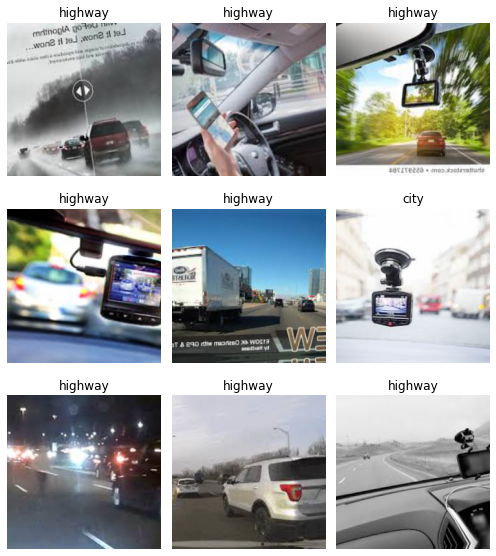

In [49]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.classes
data.show_batch(rows=3, figsize=(7,8))

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['city', 'highway'], 2, 600, 149)

## Get resnet lerner and input "data" as input

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## train we fit one cycle

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.957112,0.749629,0.248322,00:07
1,0.783431,0.754536,0.255034,00:07
2,0.675495,0.807675,0.281879,00:07
3,0.634095,0.770704,0.275168,00:07


## save trained weights 

In [0]:
learn.save('stage-1')

## unfreeze all the layers of resnet and retrain all of them

In [0]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


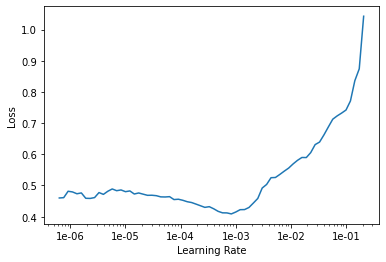

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.557605,0.768830,0.228188,00:07
1,0.572958,1.370571,0.261745,00:07


In [18]:
learn.fit_one_cycle(1, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.399063,0.908734,0.194631,00:07


In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2');

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

## check performance

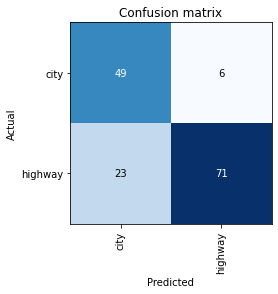

In [22]:
interp.plot_confusion_matrix()

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

## Get a new test image and show it

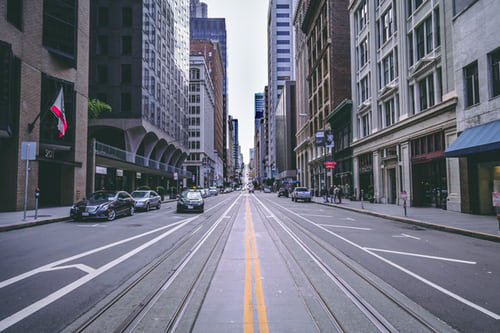

In [26]:
img = open_image(path/'city.jpg')
img

## Load lerner

In [0]:
learn = load_learner(path)

## use above image as input to lerner. We expect "city" as output

In [29]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category city

# Hurrrraaaaaaa!! 
## Our model seems to be working well

# Below is attempt of local productionizing it. Will work on local machine 

In [31]:
!pip3 install starlette

     |████████████████████████████████| 61kB 3.0MB/s 


In [32]:
!pip3 install uvicorn

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 225kB 10.2MB/s 
     |████████████████████████████████| 3.9MB 17.6MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 


In [0]:
from starlette.applications import Starlette
from starlette.responses import JSONResponse
from starlette.routing import Route

In [0]:
app = Starlette(debug=True)
@app.route('/')
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })

In [47]:
import uvicorn
uvicorn.run(app, host='0.0.0.0', port=8000)

INFO:     Started server process [124]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [124]
